In [8]:
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from PIL import Image

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2

from cv2 import *

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#import torchvision

try:
    from torchvision import models
except (ImportError, ModuleNotFoundError, AttributeError):
    models = 'models'
    





In [9]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pandas as pd
import json
import math

def read_odometer_boxes(img):
    path = 'trodo-v01/pascal voc 1.1/Annotations/'
    img = img.split('.')[0]
    tree = ET.parse(path+img+'.xml')
    root = tree.getroot()
        
    pos = []    
    for elem in root:
        for i in range(0,len(elem)):
            if elem[i].text == 'odometer':
                for coords in elem[i+2]:
                    pos.append(coords.text)
            break

    boxes = []
    xmin = pos[0]
    ymin = pos[1]
    xmax = pos[2]
    ymax = pos[3]
    boxes.append([xmin, ymin, xmax, ymax])
            
    return boxes



def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        pos = []    
        for elem in root:
            for i in range(0,len(elem)):
                if elem[i].text == 'odometer':
                    for coords in elem[i+2]:
                        pos.append(coords.text.strip())
                        #print(coords.text.strip())
                break

        boxes = []
        xmin = pos[0]
        ymin = pos[1]
        xmax = pos[2]
        ymax = pos[3]
        #boxes.append([xmin, ymin, xmax, ymax])
        anno = {}
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        #print(anno_path.split('/')[-1])
        name = anno_path.split('/')[-1].split('.')[0]
        #print(name.join('jpg'))
        anno['image'] = name + '.jpg'
        
        #anno['class'] = 'odometer'
        anno['xmin'] = math.ceil(float(xmin.strip()))
        anno['ymin'] = math.ceil(float(ymin.strip()))
        anno['xmax'] = math.floor(float(xmax.strip()))
        anno['ymax'] = math.floor(float(ymax.strip()))
        #print(anno['xmin'])
        anno_list.append(anno)
    return pd.DataFrame(anno_list)


pdXML = generate_train_df('trodo-v01/pascal voc 1.1/Annotations/')
with open('trodo-v01/ground truth/groundtruth.json','r') as f:
    groundTruth = json.loads(f.read())

groundTruth_DF = pd.json_normalize(groundTruth, record_path =['odometers'])
#### Merge together with groundtruth
newPD = pd.merge(groundTruth_DF,pdXML, how='left',left_on='image',right_on='image')

#pd.set_option('display.max_rows', None)

### Encode odometer_type Analog = 0, Digital = 1
class_dict = {'analog': 0, 'digital': 1}
newPD['odometer_type']= newPD['odometer_type'].apply(lambda x:  class_dict[x])

newPD

,image,odometer_type,mileage,width,height,xmin,ymin,xmax,ymax
0,00000002-PHOTO-2020-11-20-11-21-22.jpg,0,244362,768,1024,249,400,452,456
1,00000003-PHOTO-2020-11-20-11-21-23.jpg,1,64750,768,1024,300,414,420,485
2,00000004-PHOTO-2020-11-20-11-21-25.jpg,1,159073,1024,768,462,324,931,532
3,00000005-PHOTO-2020-11-20-11-21-26.jpg,0,18613,576,1024,217,583,333,626
4,00000006-PHOTO-2020-11-20-11-21-26.jpg,0,35376,768,1024,231,505,474,671
...,...,...,...,...,...,...,...,...,...
2384,00006473-PHOTO-2020-12-29-21-24-53.jpg,1,118818,901,1600,245,654,632,846
2385,00006474-PHOTO-2020-12-29-21-31-54.jpg,0,27203,747,1328,282,704,467,747
2386,00006496-PHOTO-2020-12-29-21-34-33.jpg,0,17611,1200,1600,476,952,696,1032
2387,00006499-PHOTO-2020-12-29-21-58-07.jpg,1,30076,738,1600,250,804,473,898


# Resizing Images and Bounding Boxes

In [10]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[6],x[5],x[8],x[7]])

def create_new_bb_array(x):
    """Generates an updated bounding box array from df, after image is resized"""
    print(np.array(x[10]))
    return np.array(x[10])

In [11]:
def read_image(path)
    return cv2.cvtColor(cv2.imread('trodo-v01/images/'+str(path)), cv2.COLOR_BGR2RGB)

In [12]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [13]:

#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('trodo-v01/images_resized')
for index, row in newPD.iterrows():
    new_path,new_bb = resize_image_bb(row['image'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)


newPD['new_path'] = new_paths
newPD['new_bb'] = new_bbs

In [14]:
im = cv2.imread('trodo-v01/images_resized/'+str(newPD.values[53][0]))


bb = create_new_bb_array(newPD.values[53])


Y = create_mask(bb, im)
mask_to_bb(Y)


[142. 169. 155. 314.]


array([142., 169., 154., 313.], dtype=float32)

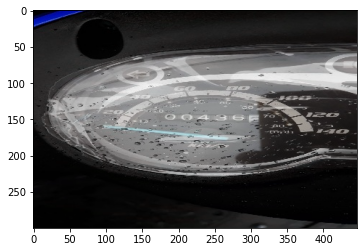

In [19]:
plt.imshow(im)
#pd.set_option('display.max_rows', None)
#newPD


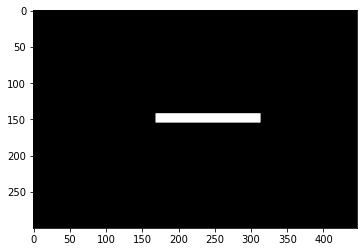

In [20]:

plt.imshow(Y, cmap='gray')

In [21]:
#pd.set_option('display.max_rows', None)
newPD


,image,odometer_type,mileage,width,height,xmin,ymin,xmax,ymax,new_path,new_bb
0,00000002-PHOTO-2020-11-20-11-21-22.jpg,0,244362,768,1024,249,400,452,456,trodo-v01/images_resized/00000002-PHOTO-2020-1...,"[117.0, 145.0, 133.0, 262.0]"
1,00000003-PHOTO-2020-11-20-11-21-23.jpg,1,64750,768,1024,300,414,420,485,trodo-v01/images_resized/00000003-PHOTO-2020-1...,"[121.0, 174.0, 141.0, 244.0]"
2,00000004-PHOTO-2020-11-20-11-21-25.jpg,1,159073,1024,768,462,324,931,532,trodo-v01/images_resized/00000004-PHOTO-2020-1...,"[126.0, 201.0, 207.0, 406.0]"
3,00000005-PHOTO-2020-11-20-11-21-26.jpg,0,18613,576,1024,217,583,333,626,trodo-v01/images_resized/00000005-PHOTO-2020-1...,"[171.0, 168.0, 183.0, 258.0]"
4,00000006-PHOTO-2020-11-20-11-21-26.jpg,0,35376,768,1024,231,505,474,671,trodo-v01/images_resized/00000006-PHOTO-2020-1...,"[148.0, 134.0, 196.0, 275.0]"
...,...,...,...,...,...,...,...,...,...,...,...
2384,00006473-PHOTO-2020-12-29-21-24-53.jpg,1,118818,901,1600,245,654,632,846,trodo-v01/images_resized/00006473-PHOTO-2020-1...,"[123.0, 121.0, 158.0, 313.0]"
2385,00006474-PHOTO-2020-12-29-21-31-54.jpg,0,27203,747,1328,282,704,467,747,trodo-v01/images_resized/00006474-PHOTO-2020-1...,"[159.0, 168.0, 168.0, 279.0]"
2386,00006496-PHOTO-2020-12-29-21-34-33.jpg,0,17611,1200,1600,476,952,696,1032,trodo-v01/images_resized/00006496-PHOTO-2020-1...,"[178.0, 177.0, 193.0, 258.0]"
2387,00006499-PHOTO-2020-12-29-21-58-07.jpg,1,30076,738,1600,250,804,473,898,trodo-v01/images_resized/00006499-PHOTO-2020-1...,"[151.0, 151.0, 167.0, 286.0]"


# Data Augmentation

In [22]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [23]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [24]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    xmin = bb[0]
    ymin = bb[1]
    xmax = bb[2]
    ymax = bb[3]
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))
    
    

    
    

trodo-v01/images_resized/00000074-PHOTO-2020-11-21-12-34-10.jpg


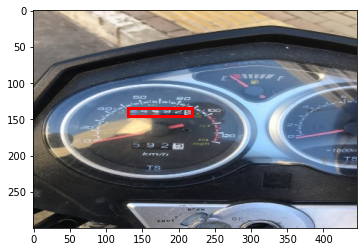

In [25]:
print(str(newPD.values[68][9]))
im = cv2.imread(str(newPD.values[68][9]))

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, newPD.values[68][10])

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


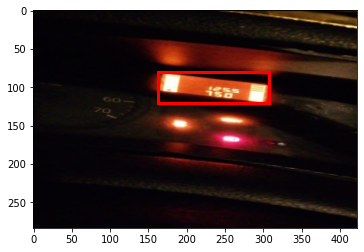

In [26]:
im, bb = transformsXY(str(newPD.values[75][9]),newPD.values[75][10],True)
show_corner_bb(im, bb)

# Train-valid split

In [27]:
df_train = newPD.reset_index()

df_train

,index,image,odometer_type,mileage,width,height,xmin,ymin,xmax,ymax,new_path,new_bb
0,0,00000002-PHOTO-2020-11-20-11-21-22.jpg,0,244362,768,1024,249,400,452,456,trodo-v01/images_resized/00000002-PHOTO-2020-1...,"[117.0, 145.0, 133.0, 262.0]"
1,1,00000003-PHOTO-2020-11-20-11-21-23.jpg,1,64750,768,1024,300,414,420,485,trodo-v01/images_resized/00000003-PHOTO-2020-1...,"[121.0, 174.0, 141.0, 244.0]"
2,2,00000004-PHOTO-2020-11-20-11-21-25.jpg,1,159073,1024,768,462,324,931,532,trodo-v01/images_resized/00000004-PHOTO-2020-1...,"[126.0, 201.0, 207.0, 406.0]"
3,3,00000005-PHOTO-2020-11-20-11-21-26.jpg,0,18613,576,1024,217,583,333,626,trodo-v01/images_resized/00000005-PHOTO-2020-1...,"[171.0, 168.0, 183.0, 258.0]"
4,4,00000006-PHOTO-2020-11-20-11-21-26.jpg,0,35376,768,1024,231,505,474,671,trodo-v01/images_resized/00000006-PHOTO-2020-1...,"[148.0, 134.0, 196.0, 275.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2384,2384,00006473-PHOTO-2020-12-29-21-24-53.jpg,1,118818,901,1600,245,654,632,846,trodo-v01/images_resized/00006473-PHOTO-2020-1...,"[123.0, 121.0, 158.0, 313.0]"
2385,2385,00006474-PHOTO-2020-12-29-21-31-54.jpg,0,27203,747,1328,282,704,467,747,trodo-v01/images_resized/00006474-PHOTO-2020-1...,"[159.0, 168.0, 168.0, 279.0]"
2386,2386,00006496-PHOTO-2020-12-29-21-34-33.jpg,0,17611,1200,1600,476,952,696,1032,trodo-v01/images_resized/00006496-PHOTO-2020-1...,"[178.0, 177.0, 193.0, 258.0]"
2387,2387,00006499-PHOTO-2020-12-29-21-58-07.jpg,1,30076,738,1600,250,804,473,898,trodo-v01/images_resized/00006499-PHOTO-2020-1...,"[151.0, 151.0, 167.0, 286.0]"


In [28]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['odometer_type']

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [30]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [31]:
class OdometerDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [32]:
train_ds = OdometerDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = OdometerDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [33]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Model MF

In [34]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [35]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [36]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cpu().float()
            y_class = y_class.cpu()
            y_bb = y_bb.cpu().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [37]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cpu().float()
        y_class = y_class.cpu()
        y_bb = y_bb.cpu().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
!export CUDA_VISIBLE_DEVICES=""
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)



AttributeError: 'str' object has no attribute 'resnet34'

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


# Old Shit


In [ ]:
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
#!unzip PennFudanPed.zip

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.CenterCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


In [3]:
import os
import numpy as np
import torch
from PIL import Image



class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path)

        img_path = img_path.split('/')[-1]
        # with 0 being background
        #mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(img)
        print(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        
        # get bounding box coordinates for each mask
        #print('img_path',img_path)
        

        boxes = read_odometer_boxes(img_path)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [28]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [30]:
import xml.etree.ElementTree as ET

def read_odometer_boxes(img):
    path = 'Train-trodo/pascal voc 1.1/Annotations/'
    img = img.split('.')[0]
    tree = ET.parse(path+img+'.xml')
    root = tree.getroot()
        
    pos = []    
    for elem in root:
        for i in range(0,len(elem)):
            if elem[i].text == 'odometer':
                for coords in elem[i+2]:
                    pos.append(coords.text)
            break

    boxes = []
    xmin = pos[0]
    ymin = pos[1]
    xmax = pos[2]
    ymax = pos[3]
    boxes.append([xmin, ymin, xmax, ymax])
            
    return boxes

#read_odometer_boxes('00000002-PHOTO-2020-11-20-11-21-22.jpg')


In [31]:
        # Returns predictions

In [32]:
from engine import train_one_epoch, evaluate
import utils
from pycocotools.coco import COCO



def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('Train-trodo',train_transforms)
    dataset_test = PennFudanDataset('Test-trodo-350',test_transforms)

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    #model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")
main()

[[[10  4 16]
  [10  4 16]
  [10  4 16]
  ...
  [ 6  4 17]
  [ 6  4 17]
  [ 6  4 17]]

 [[10  4 16]
  [10  4 16]
  [10  4 16]
  ...
  [ 6  4 17]
  [ 6  4 17]
  [ 6  4 17]]

 [[10  4 16]
  [10  4 16]
  [10  4 16]
  ...
  [ 6  4 17]
  [ 6  4 17]
  [ 6  4 17]]

 ...

 [[ 7  3 17]
  [ 7  3 17]
  [ 7  3 17]
  ...
  [24 20 19]
  [25 21 20]
  [26 22 21]]

 [[ 7  3 17]
  [ 7  3 17]
  [ 7  3 17]
  ...
  [24 20 19]
  [25 21 20]
  [25 21 20]]

 [[ 7  3 17]
  [ 7  3 17]
  [ 7  3 17]
  ...
  [23 19 18]
  [24 20 19]
  [25 21 20]]]
[[[ 83  95  85]
  [ 92 104  94]
  [ 97 108 100]
  ...
  [ 89  73  73]
  [101  85  86]
  [ 99  83  84]]

 [[ 85  97  87]
  [ 92 104  94]
  [ 95 106  98]
  ...
  [ 87  71  71]
  [ 97  81  82]
  [ 95  79  80]]

 [[ 88 100  90]
  [ 93 105  95]
  [ 95 105  97]
  ...
  [ 90  76  76]
  [ 97  82  85]
  [ 97  82  85]]

 ...

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [215 220 216]
  [216 221 217]
  [217 222 218]]

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[[[28 20 31]
  [26 20 30]
  [20 19 27]
  ...
  [20  5  8]
  [20  5  8]
  [20  5  8]]

 [[27 19 30]
  [25 19 29]
  [19 18 26]
  ...
  [20  5  8]
  [20  5  8]
  [20  5  8]]

 [[25 17 28]
  [23 17 27]
  [17 16 24]
  ...
  [20  5  8]
  [20  5  8]
  [20  5  8]]

 ...

 [[69 69 67]
  [69 69 67]
  [70 70 68]
  ...
  [22 16 18]
  [23 17 19]
  [23 17 19]]

 [[68 68 66]
  [68 68 66]
  [69 69 67]
  ...
  [22 16 18]
  [23 17 19]
  [24 18 20]]

 [[67 67 65]
  [68 68 66]
  [69 69 67]
  ...
  [22 16 18]
  [23 17 19]
  [24 18 20]]]
[[[14 12 17]
  [14 12 17]
  [14 12 17]
  ...
  [17 15 20]
  [16 14 19]
  [16 14 19]]

 [[14 12 17]
  [14 12 17]
  [14 12 17]
  ...
  [17 15 20]
  [16 14 19]
  [16 14 19]]

 [[14 12 17]
  [14 12 17]
  [14 12 17]
  ...
  [17 15 20]
  [17 15 20]
  [17 15 20]]

 ...

 [[21 20 25]
  [21 20 25]
  [21 20 25]
  ...
  [16 11 18]
  [14  9 16]
  [14  9 16]]

 [[21 20 25]
  [21 20 25]
  [21 20 25]
  ...
  [16 11 18]
  [14  9 16]
  [14  9 16]]

 [[21 20 25]
  [21 20 25]
  [21 20 25]
  .

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/eric/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 363, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<ipython-input-27-17e08e029942>", line 45, in __getitem__
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
ValueError: too many dimensions 'str'


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[[[240 243 248]
  [240 243 248]
  [241 244 249]
  ...
  [197 192 189]
  [197 192 189]
  [197 192 189]]

 [[240 243 248]
  [240 243 248]
  [240 243 248]
  ...
  [197 192 189]
  [197 192 189]
  [197 192 189]]

 [[239 242 247]
  [239 242 247]
  [240 243 248]
  ...
  [194 190 189]
  [194 190 189]
  [194 190 189]]

 ...

 [[195 196 198]
  [195 196 198]
  [200 201 203]
  ...
  [168 172 173]
  [166 170 171]
  [165 169 170]]

 [[194 195 197]
  [193 194 196]
  [197 198 200]
  ...
  [172 176 177]
  [171 175 176]
  [169 173 174]]

 [[191 192 194]
  [190 191 193]
  [193 194 196]
  ...
  [175 179 180]
  [173 177 178]
  [172 176 177]]]
[[[ 71  67  66]
  [ 76  72  71]
  [ 78  74  73]
  ...
  [ 67  55  55]
  [ 70  58  58]
  [ 75  63  63]]

 [[ 66  62  61]
  [ 72  68  67]
  [ 76  72  71]
  ...
  [ 69  57  57]
  [ 71  59  59]
  [ 75  63  63]]

 [[ 65  61  60]
  [ 71  67  66]
  [ 75  71  70]
  ...
  [ 72  60  60]
  [ 74  62  62]
  [ 75  63  63]]

 ...

 [[220 210 201]
  [220 210 201]
  [221 211 202]
  ..

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[[[ 95  91  79]
  [ 94  90  78]
  [ 93  89  77]
  ...
  [ 55  55  53]
  [ 53  53  51]
  [ 46  46  44]]

 [[ 95  91  79]
  [ 95  91  79]
  [ 94  90  78]
  ...
  [ 52  52  50]
  [ 49  49  47]
  [ 42  42  40]]

 [[ 95  91  79]
  [ 95  91  79]
  [ 95  91  79]
  ...
  [ 50  50  48]
  [ 47  47  45]
  [ 42  42  40]]

 ...

 [[156 146 136]
  [157 147 137]
  [157 147 137]
  ...
  [170 171 166]
  [169 170 165]
  [170 171 166]]

 [[157 147 137]
  [158 148 138]
  [158 148 138]
  ...
  [167 168 163]
  [166 167 162]
  [166 167 162]]

 [[158 148 138]
  [158 148 138]
  [158 148 138]
  ...
  [166 167 162]
  [165 166 161]
  [165 166 161]]]
